In [1]:
# RUN THIS LINE ONLY ONCE !!!
import sys
import os
os.chdir('../')
sys.path.append(os.getcwd())

In [2]:
from utils import get_dataset, validate
from learner import Learner
from schedulers import CyclicLRDecay
import random
import torch
import torch.nn as nn
from torch.optim import AdamW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# If you have dark theme
from matplotlib.pyplot import rcParams
rcParams['figure.facecolor'] = 'white'

In [4]:
# Setup logger
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s : %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

In [5]:
dataset, emb_weights = get_dataset()
# dataset.fields['review'].include_lengths = True

random.seed(43)
ds_train, ds_val, ds_test = dataset.split(split_ratio=[0.8, 0.1, 0.1], random_state=random.getstate())

06/01/2020 11:50:01 PM INFO : Downloading data
06/01/2020 11:50:02 PM INFO : Downloading GloVe word vectors
06/01/2020 11:50:02 PM INFO : Loading vectors from .vector_cache/glove.6B.300d.txt.pt
06/01/2020 11:50:09 PM INFO : Loading vectors from .vector_cache/glove.6B.300d.txt.pt


In [61]:
class CNN(nn.Module):
    def __init__(self, out_channels, kernel_heights, stride, padding, dropout, emb_weights):
        super().__init__()

        self.out_channels = out_channels
        self.kernel_heights = kernel_heights
        self.stride = stride
        self.padding = padding
        self.embedding_length = emb_weights.shape[1]

        self.word_embeddings = nn.Embedding.from_pretrained(emb_weights)
        self.conv1 = nn.Conv2d(1, out_channels, (kernel_heights[0], self.embedding_length), stride, (padding[0], 0))
        self.conv2 = nn.Conv2d(1, out_channels, (kernel_heights[1], self.embedding_length), stride, (padding[1], 0))
        self.conv3 = nn.Conv2d(1, out_channels, (kernel_heights[2], self.embedding_length), stride, (padding[2], 0))
        self.conv4 = nn.Conv2d(1, out_channels, (kernel_heights[3], self.embedding_length), stride, (padding[3], 0))
        self.dropout0 = nn.Dropout(p=dropout[0])
        self.dropout1 = nn.Dropout(p=dropout[1])
        self.relu = nn.ReLU()
        self.head = nn.Linear(len(kernel_heights)*out_channels, 2)

    def conv_block(self, input, conv_layer):
        conv_out = conv_layer(input)# conv_out.size() = (batch_size, out_channels, dim, 1)
        activation = self.relu(conv_out.squeeze(3))# activation.size() = (batch_size, out_channels, dim1)
        max_out = nn.functional.max_pool1d(activation, activation.size()[2]).squeeze(2)# maxpool_out.size() = (batch_size, out_channels)

        return max_out

    def forward(self, batch):
        input = self.word_embeddings(batch).unsqueeze(1)
        input = self.dropout0(input)

        max_out = []
        max_out.append(self.conv_block(input, self.conv1))
        max_out.append(self.conv_block(input, self.conv2))
        max_out.append(self.conv_block(input, self.conv3))
        max_out.append(self.conv_block(input, self.conv4))

        all_out = torch.cat(max_out, dim=1)

        return self.head(self.dropout1(all_out))

In [154]:
model = CNN(out_channels=8, kernel_heights=(1, 3, 5, 7), stride=1, padding=(0, 1, 2, 3),
            dropout=(0.45, 0.4), emb_weights=emb_weights.clone())
loss_fn = nn.CrossEntropyLoss().to(device)
optimiser = AdamW(model.parameters(), lr=3e-3, weight_decay=1e-3)
cycle_steps = 2*(len(ds_train)//32 + 1)
scheduler = CyclicLRDecay(optimiser, 3e-5, 5e-3, cycle_steps, 0.25, gamma_factor=0.75)
learner = Learner(model, loss_fn, optimiser, scheduler, ds_train, ds_val, device)

1.00%

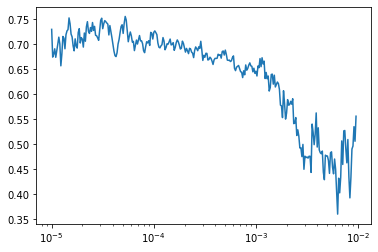

In [8]:
learner.lr_finder(bs=32, lr_range=(1e-5, 1e-2))

In [155]:
learner.train(epochs=10, bs=32, grad_clip=(0.17, 1.6))

06/02/2020 12:56:14 AM INFO : Epoch : 1, batch : 18, train_loss = 0.6944, val_loss = 0.6629, val_accuracy : 0.613, time = 0s
06/02/2020 12:56:14 AM INFO : Epoch : 1, batch : 36, train_loss = 0.6274, val_loss = 0.5609, val_accuracy : 0.757, time = 1s
06/02/2020 12:56:14 AM INFO : Epoch : 1, batch : 54, train_loss = 0.5780, val_loss = 0.4807, val_accuracy : 0.787, time = 1s
06/02/2020 12:56:15 AM INFO : Epoch : 1, batch : 72, train_loss = 0.4842, val_loss = 0.4449, val_accuracy : 0.800, time = 1s
06/02/2020 12:56:15 AM INFO : Epoch : 2, batch : 18, train_loss = 0.4572, val_loss = 0.3819, val_accuracy : 0.843, time = 2s
06/02/2020 12:56:15 AM INFO : Epoch : 2, batch : 36, train_loss = 0.4021, val_loss = 0.3558, val_accuracy : 0.850, time = 2s
06/02/2020 12:56:16 AM INFO : Epoch : 2, batch : 54, train_loss = 0.4036, val_loss = 0.3528, val_accuracy : 0.880, time = 3s
06/02/2020 12:56:16 AM INFO : Epoch : 2, batch : 72, train_loss = 0.4627, val_loss = 0.3408, val_accuracy : 0.883, time = 3s


In [156]:
model.word_embeddings.weight.requires_grad_(True);
learner.train(epochs=6, bs=32, grad_clip=(0.17, 1.6))

06/02/2020 12:56:39 AM INFO : Epoch : 1, batch : 18, train_loss = 0.2682, val_loss = 0.3004, val_accuracy : 0.880, time = 1s
06/02/2020 12:56:40 AM INFO : Epoch : 1, batch : 36, train_loss = 0.2583, val_loss = 0.2955, val_accuracy : 0.877, time = 2s
06/02/2020 12:56:41 AM INFO : Epoch : 1, batch : 54, train_loss = 0.2599, val_loss = 0.2980, val_accuracy : 0.883, time = 3s
06/02/2020 12:56:42 AM INFO : Epoch : 1, batch : 72, train_loss = 0.2717, val_loss = 0.2915, val_accuracy : 0.873, time = 4s
06/02/2020 12:56:43 AM INFO : Epoch : 2, batch : 18, train_loss = 0.2278, val_loss = 0.2855, val_accuracy : 0.867, time = 6s
06/02/2020 12:56:45 AM INFO : Epoch : 2, batch : 36, train_loss = 0.2423, val_loss = 0.2890, val_accuracy : 0.877, time = 7s
06/02/2020 12:56:46 AM INFO : Epoch : 2, batch : 54, train_loss = 0.2491, val_loss = 0.2875, val_accuracy : 0.877, time = 8s
06/02/2020 12:56:47 AM INFO : Epoch : 2, batch : 72, train_loss = 0.2358, val_loss = 0.2829, val_accuracy : 0.880, time = 9s


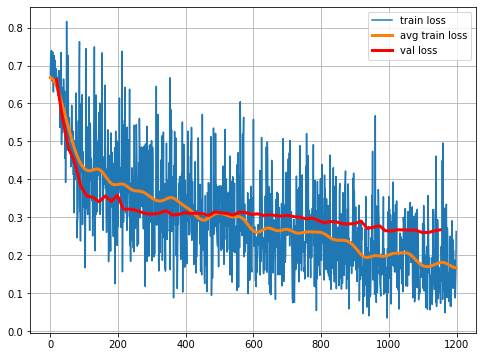

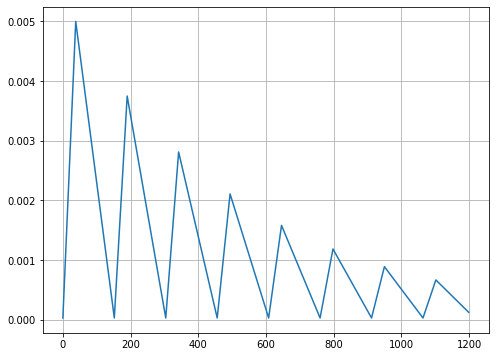

In [157]:
learner.recorder.plot_losses(show_lr=True)

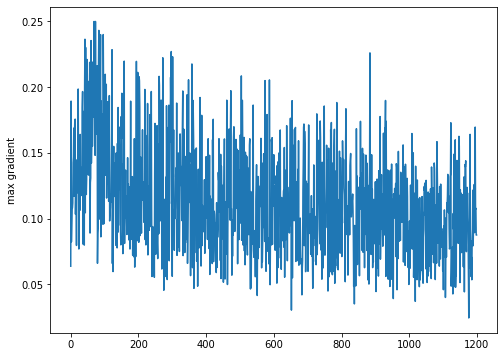

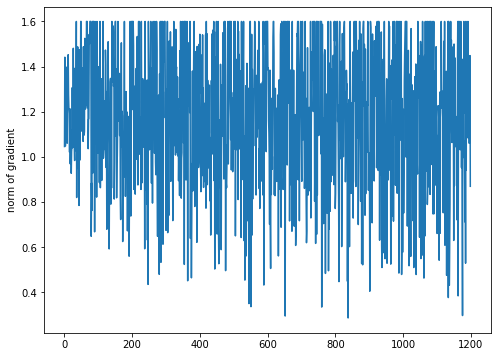

In [71]:
learner.recorder.plot_grads()

In [158]:
print('Test loss : {:.5f}, test accuracy : {:.03f}'.format(*validate(ds_test, loss_fn, model)))

Test loss : 0.25772, test accuracy : 0.887


<br>

In [75]:
class CNN2(nn.Module):
    def __init__(self, out_channels, kernel_heights, stride, padding, dropout, emb_weights):
        super().__init__()
        
        self.out_channels = out_channels
        self.kernel_heights = kernel_heights
        self.stride = stride
        self.padding = padding
        self.embedding_length = emb_weights.shape[1]

        self.word_embeddings = nn.Embedding.from_pretrained(emb_weights)
        self.conv1 = nn.Conv2d(1, out_channels, (kernel_heights[0], self.embedding_length), stride, (padding[0], 0))
        self.conv2 = nn.Conv2d(out_channels, 2*out_channels, (kernel_heights[1], 1), stride, (padding[1], 0))
        self.conv3 = nn.Conv2d(2*out_channels, 4*out_channels, (kernel_heights[2], 1), stride, (padding[2], 0))
        self.dropout0 = nn.Dropout(p=dropout[0])
        self.dropout1 = nn.Dropout(p=dropout[1])
        self.relu = nn.ReLU()
        self.head = nn.Linear(4*out_channels, 2)

    def forward(self, batch):
        input = self.word_embeddings(batch).unsqueeze(1)
        # input.size() = (batch_size, 1, num_seq, embedding_length)
        
        out = self.relu(self.conv1(self.dropout0(input)))
        out = self.relu(self.conv2(self.dropout0(out)))
        out = self.relu(self.conv3(self.dropout0(out)))
        max_out = max_out = nn.functional.max_pool1d(out.squeeze(3), out.size()[2]).squeeze(2)

        return self.head(self.dropout1(max_out))

In [129]:
model = CNN2(out_channels=32, kernel_heights=(1, 3, 3), stride=1, padding=(0, 1, 1),
             dropout=(0.3, 0.35), emb_weights=emb_weights.clone())
loss_fn = nn.CrossEntropyLoss().to(device)
optimiser = AdamW(model.parameters(), lr=3e-3, weight_decay=1e-3)
cycle_steps = 2*(len(ds_train)//32 + 1)
scheduler = CyclicLRDecay(optimiser, 1e-4, 5e-3, cycle_steps, 0.25, gamma_factor=0.75)
learner = Learner(model, loss_fn, optimiser, scheduler, ds_train, ds_val, device)

1.00%

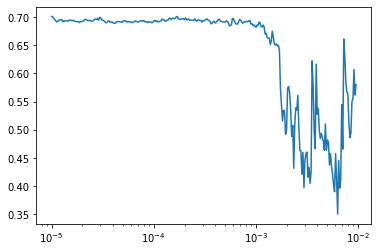

In [77]:
learner.lr_finder(bs=32, lr_range=(1e-5, 1e-2))

In [130]:
learner.train(epochs=10, bs=32, grad_clip=(0.2, 1.5))

06/02/2020 12:46:23 AM INFO : Epoch : 1, batch : 18, train_loss = 0.6921, val_loss = 0.6937, val_accuracy : 0.473, time = 0s
06/02/2020 12:46:23 AM INFO : Epoch : 1, batch : 36, train_loss = 0.6799, val_loss = 0.6352, val_accuracy : 0.740, time = 1s
06/02/2020 12:46:24 AM INFO : Epoch : 1, batch : 54, train_loss = 0.5974, val_loss = 0.4975, val_accuracy : 0.783, time = 1s
06/02/2020 12:46:24 AM INFO : Epoch : 1, batch : 72, train_loss = 0.5220, val_loss = 0.5501, val_accuracy : 0.713, time = 1s
06/02/2020 12:46:24 AM INFO : Epoch : 2, batch : 18, train_loss = 0.4927, val_loss = 0.4587, val_accuracy : 0.783, time = 2s
06/02/2020 12:46:25 AM INFO : Epoch : 2, batch : 36, train_loss = 0.4195, val_loss = 0.3987, val_accuracy : 0.837, time = 2s
06/02/2020 12:46:25 AM INFO : Epoch : 2, batch : 54, train_loss = 0.4436, val_loss = 0.3629, val_accuracy : 0.863, time = 2s
06/02/2020 12:46:25 AM INFO : Epoch : 2, batch : 72, train_loss = 0.4122, val_loss = 0.3535, val_accuracy : 0.857, time = 2s


In [131]:
model.word_embeddings.weight.requires_grad_(True);
learner.train(epochs=6, bs=32, grad_clip=(0.2, 1.5))

06/02/2020 12:46:38 AM INFO : Epoch : 1, batch : 18, train_loss = 0.2872, val_loss = 0.2888, val_accuracy : 0.867, time = 1s
06/02/2020 12:46:39 AM INFO : Epoch : 1, batch : 36, train_loss = 0.2445, val_loss = 0.2903, val_accuracy : 0.873, time = 2s
06/02/2020 12:46:40 AM INFO : Epoch : 1, batch : 54, train_loss = 0.2994, val_loss = 0.2877, val_accuracy : 0.867, time = 3s
06/02/2020 12:46:41 AM INFO : Epoch : 1, batch : 72, train_loss = 0.2587, val_loss = 0.2823, val_accuracy : 0.870, time = 4s
06/02/2020 12:46:43 AM INFO : Epoch : 2, batch : 18, train_loss = 0.1923, val_loss = 0.2843, val_accuracy : 0.873, time = 5s
06/02/2020 12:46:44 AM INFO : Epoch : 2, batch : 36, train_loss = 0.1929, val_loss = 0.2904, val_accuracy : 0.867, time = 6s
06/02/2020 12:46:45 AM INFO : Epoch : 2, batch : 54, train_loss = 0.2273, val_loss = 0.2773, val_accuracy : 0.880, time = 7s
06/02/2020 12:46:46 AM INFO : Epoch : 2, batch : 72, train_loss = 0.2770, val_loss = 0.2741, val_accuracy : 0.880, time = 8s


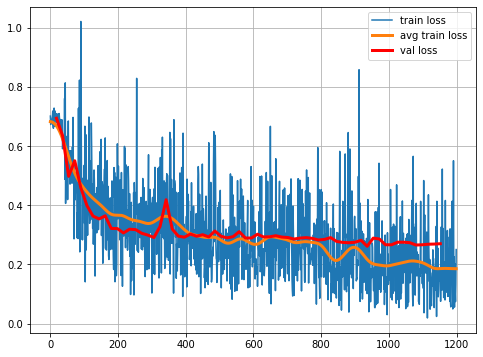

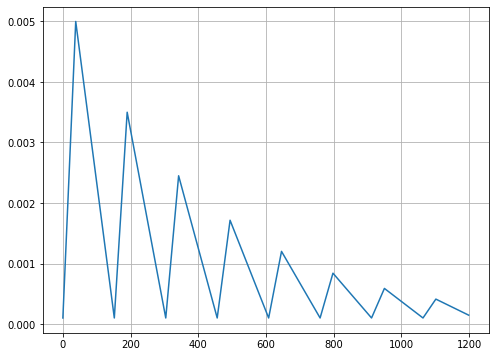

In [133]:
learner.recorder.plot_losses(show_lr=True)

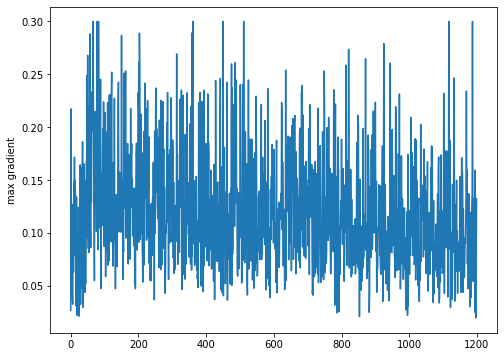

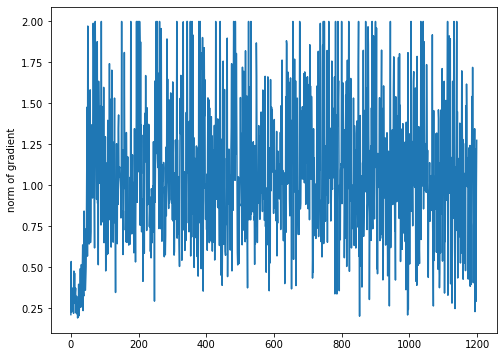

In [118]:
learner.recorder.plot_grads()

In [132]:
print('Test loss : {:.5f}, test accuracy : {:.03f}'.format(*validate(ds_test, loss_fn, model)))

Test loss : 0.25391, test accuracy : 0.907


<br>

### Look at some predictions

In [203]:
import numpy as np

In [299]:
def most_confused(ds, loss_fn, model, top_k=5, device=device):
    is_in_train = model.training
    model.eval()
    with torch.no_grad():
        predictions = []
        gt = []
        losses = []
        reviews = []
        for i, batch in enumerate(MyIterator(ds, 1, sort_key=lambda x: len(x.review), shuffle=False, train=False, device=device)):
            output = model(batch.review)
            predictions.extend(output.argmax(dim=1).tolist())
            gt.extend(batch.label.tolist())
            losses.append(loss_fn(output, batch.label).item())
            reviews.append(batch.review)
            
    vocab = ds.fields['review'].vocab
    preds = np.array([losses, list(range(len(reviews))), predictions, gt]).transpose()
    wrong_preds = preds[preds[:,2] != preds[:,3]]
    wrong_preds_sorted = np.array(sorted(wrong_preds[:], key=lambda x: x[0]))
    top_k_wrong = wrong_preds_sorted[:top_k,:]
    top_k_wrong = [(loss, ' '.join([vocab.itos[i] for i in reviews[int(review_id)][0].tolist()]), 'gt: {}, pred : {}'.format(gt, pred)) for (loss, review_id, pred, gt) in top_k_wrong]
    
    if is_in_train: model.train()    
    return top_k_wrong

In [301]:
most_confused(ds_val, loss_fn, model, top_k=10)

[(0.7110309600830078, "better than you 'd expect .", 'gt: 1.0, pred : 0.0'),
 (0.7474281787872314,
  'i dressed up to be treated so rudely !',
  'gt: 0.0, pred : 1.0'),
 (0.7563066482543945,
  'the only thing i did like was the prime rib and dessert section .',
  'gt: 1.0, pred : 0.0'),
 (0.7787615656852722, 'i just wanted to leave .', 'gt: 0.0, pred : 1.0'),
 (0.8162384033203125,
  'i ordered this for sony ericsson <unk> but i think it only worked once ( that s when i first used it ) .',
  'gt: 0.0, pred : 1.0'),
 (0.8669049739837646,
  'motorola finally got the voice quality of a bluetooth headset right .',
  'gt: 1.0, pred : 0.0'),
 (0.9086286425590515,
  "the best example of how dumb the writing is when it 's established that you can turn the zombie - students back into humans by removing a necklace containing a piece of the meteorite .",
  'gt: 0.0, pred : 1.0'),
 (0.979867696762085,
  'kris kristoffersen is good in this movie and really makes a difference .',
  'gt: 1.0, pred : 0